In [2]:
import numpy as np
import pronouncing
import markovify
import re as regexp
import random
import os
import keras
import time

from keras.layers import LSTM 
from keras.models import Sequential

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

%matplotlib inline

In [3]:
def plot_word_frequency(file):
    f = open(file, 'r')
    words = [x for y in [l.split() for l in f.readlines()] for x in y]
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.title('Most Commonly Used Words: %s' % (file), fontsize=24)
    plt.show()

In [4]:
def read_file(file):
	text = open(file, encoding='utf-8').read()
	text = text.split("\n")
	while "" in text:
		text.remove("")
	return text

In [5]:
def create_lstm_network(depth, author, file):
	model = Sequential()
	model.add(LSTM(4, input_shape=(2, 2), return_sequences=True))
	for i in range(depth):
		model.add(LSTM(8, return_sequences=True))
	model.add(LSTM(2, return_sequences=True))
	model.summary()
	model.compile(optimizer='rmsprop', loss='mse')

	weights_file = "tmp.work." + author + "." + file
	if weights_file in os.listdir(".") and train_mode == False:
		model.load_weights(weights_file)
		print("Loading Saved Weights: " + weights_file)
	return model

In [6]:
def create_markov_model(file):
	read = open(file, "r", encoding='utf-8').read()
	text_model = markovify.NewlineText(read)
	return text_model

In [7]:
def syllables_frequency(max_syllables, line):
	count = 0
	if len(line.strip()) > 0:
		for word in line.strip().split(" "):
			vowels = 'aeiouy'
			word = word.lower().strip(".:;?!-,।‘").strip()
			if len(word) > 0 and word[0] in vowels:
				count +=1
			for index in range(1, len(word)):
				if word[index] in vowels and word[index-1] not in vowels:
					count +=1
			if word.endswith('e'):
				count -= 1
			if word.endswith('le'):
				count+=1
			if len(word) > 0 and count == 0:
				count +=1
	return count / max_syllables

In [8]:
def rhyme_index(train_mode, author, file, lyrics):
	rhymes_file = "tmp.rhymes." + str(author) + "." + file
	if rhymes_file in os.listdir(".") and train_mode == False:
		print ("loading saved rhymes from " + rhymes_file)
		return open(rhymes_file, "r",encoding='utf-8').read().split("\n")
	else:
		rhyme_master_list = []
		print ("Building list of rhymes:")
		for i in lyrics:
			word = regexp.sub(r"\W+", '', i.split(" ")[-1]).lower()
			rhymes_list = pronouncing.rhymes(word)
			rhymes_list_ends = []      
			for i in rhymes_list:
				rhymes_list_ends.append(i[-2:])
			try:
				rhyme_scheme = max(set(rhymes_list_ends), key=rhymes_list_ends.count)
			except Exception:
				rhyme_scheme = word[-2:]
			rhyme_master_list.append(rhyme_scheme)
		rhyme_master_list = list(set(rhyme_master_list))
		reverse_list = [x[::-1] for x in rhyme_master_list]
		reverse_list = sorted(reverse_list)
		rhyme_list = [x[::-1] for x in reverse_list]
		print("List of 2-Letter rhyme ends:")
		print(rhyme_list)
		f = open(rhymes_file, "w", encoding='utf-8')
		f.write("\n".join(rhyme_list))
		f.close()
		return rhyme_list

In [9]:
def rhyme(line, rhyme_list):
	word = regexp.sub(r"\W+", '', line.split(" ")[-1]).lower()
	rhymes_list = pronouncing.rhymes(word)
	rhymes_list_ends = []
	for i in rhymes_list:
		rhymes_list_ends.append(i[-2:])
	try:
		rhyme_scheme = max(set(rhymes_list_ends), key=rhymes_list_ends.count)
	except Exception:
		rhyme_scheme = word[-2:]
	try:
		float_rhyme = rhyme_list.index(rhyme_scheme)
		float_rhyme = float_rhyme / float(len(rhyme_list))
		return float_rhyme
	except Exception:
		float_rhyme = None
		return float_rhyme

In [10]:
def build_dataset(max_syllables, lines, rhyme_list):
	dataset = []
	line_list = []
	for line in lines:
		line_list = [line, syllables_frequency(max_syllables, line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	x_data = []
	y_data = []
	for i in range(len(dataset) - 3):
		line1 = dataset[i    ][1:]
		line2 = dataset[i + 1][1:]
		line3 = dataset[i + 2][1:]
		line4 = dataset[i + 3][1:]
		x = [line1[0], line1[1], line2[0], line2[1]]
		x = np.array(x)
		x = x.reshape(2,2)
		x_data.append(x)
		y = [line3[0], line3[1], line4[0], line4[1]]
		y = np.array(y)
		y = y.reshape(2,2)
		y_data.append(y)
	x_data = np.array(x_data)
	y_data = np.array(y_data)
	return x_data, y_data

In [11]:
def train(author, file, x_data, y_data, model):
	if os.path.exists("checkpoint"): os.remove("checkpoint")
	weights_file = "tmp.work." + author + "." + file
	model.fit(np.array(x_data), np.array(y_data),
			  batch_size=2,
			  epochs=5,
			  verbose=1)
	model.save_weights(weights_file)
	if os.path.exists("checkpoint"): os.remove("checkpoint")    

In [12]:
def compose_verse_bars(max_syllables, text_model, text_file):
	bars = []
	last_words = []
	length = len(open(text_file,encoding='utf-8').read().split("\n"))
	count = 0
	markov_model = create_markov_model(text_file)
	bars_count = length / (random.randint(1,8) * 10)
	start_time = time.process_time()

	while len(bars) < bars_count and count < length * 2 and (time.process_time() - start_time) < 15:
		bar = markov_model.make_sentence(max_overlap_ratio = .49, tries=100)
		if type(bar) != type(None) and syllables_frequency(max_syllables, bar) < 1:
			def get_last_word(bar):
				last_word = bar.split(" ")[-1]
				if last_word[-1] in "!.?,":
					last_word = last_word[:-1]
				return last_word
			last_word = get_last_word(bar)
			if bar not in bars and last_words.count(last_word) < 3:
				start_time = time.process_time()
				print("Composed " + str(len(bars)) + "/" + str(int(bars_count)) + " verses.")
				bars.append(bar)
				last_words.append(last_word)
				count += 1
	return bars

In [13]:
def compose_verse(max_syllables, lines, rhyme_list, file, model):
	verses_vectors = []
	human_lyrics = read_file(file)
	initial_index = random.choice(range(len(human_lyrics) - 1))
	initial_lines = human_lyrics[initial_index:initial_index + 2]
	starting_input = []
	for line in initial_lines:
		starting_input.append([syllables_frequency(max_syllables, line), rhyme(line, rhyme_list)])
	starting_vectors = model.predict(np.array([starting_input]).flatten().reshape(1, 2, 2))
	verses_vectors.append(starting_vectors)
	for i in range(100):
		verses_vectors.append(model.predict(np.array([verses_vectors[-1]]).flatten().reshape(1, 2, 2)))
	return verses_vectors

In [14]:
def compose(max_syllables, vectors, generated_lyrics, rhyme_list):
	print ("\n\n")	
	print ("Composing:")
	print ("\n\n")
	def last_word_compare(verses, line2):
		penalty = 0 
		for line1 in verses:
			word1 = line1.split(" ")[-1]
			word2 = line2.split(" ")[-1]
			while word1[-1] in "?!,. ":
				word1 = word1[:-1]
			while word2[-1] in "?!,. ":
				word2 = word2[:-1]
			if word1 == word2:
				penalty += 0.2
		return penalty
	def calculate_score(vector_half, syllables, rhyme, penalty):
		desired_syllables = vector_half[0]
		desired_rhyme = vector_half[1]
		desired_syllables = desired_syllables * max_syllables
		desired_rhyme = desired_rhyme * len(rhyme_list)
		score = 1.0 - abs(float(desired_syllables) - float(syllables)) + abs(float(desired_rhyme) - float(rhyme)) - penalty
		return score
	dataset = []
	for line in generated_lyrics:
		line_list = [line, syllables_frequency(max_syllables, line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	verses = []
	vector_halves = []
	for vector in vectors:
		vector_halves.append(list(vector[0][0])) 
		vector_halves.append(list(vector[0][1]))
	for vector in vector_halves:
		score_list = []
		for item in dataset:
			line = item[0]
			if len(verses) != 0:
				penalty = last_word_compare(verses, line)
			else:
				penalty = 0
			total_score = calculate_score(vector, item[1], item[2], penalty)
			score_entry = [line, total_score]
			score_list.append(score_entry)
		fixed_score_list = [0]
		for score in score_list:
			fixed_score_list.append(float(score[1]))
		max_score = max(fixed_score_list)
		for item in score_list:
			if item[1] == max_score:
				verses.append(item[0])
				print (str(item[0]))
				for i in dataset:
					if item[0] == i[0]:
						dataset.remove(i)
						break
				break     
	return verses

In [15]:
def train_or_compose(depth, max_syllables, author, file, train_mode):
	abs_file = './' + author + "/" + file
	model = create_lstm_network(depth, author, file)
	text_model = create_markov_model(abs_file)
	if train_mode == True:
		bars = read_file(abs_file)
	else:
		bars = compose_verse_bars(max_syllables, text_model, abs_file)

	rhyme_list = rhyme_index(train_mode, author, file, bars)

	if train_mode == True:
		x_data, y_data = build_dataset(max_syllables, bars, rhyme_list)
		train(author, file, x_data, y_data, model)
	else:
		vectors = compose_verse(max_syllables, bars, rhyme_list, abs_file, model)
		verses = compose(max_syllables, vectors, bars, rhyme_list)
		f = open('./' + author + "/composed." + file, "w", encoding='utf-8')
		for bar in verses:
			f.write(bar)
			f.write("\n")

In [16]:
def main(author, file):
	depth = 4
	max_syllables = 8
	author_image = mpimg.imread('./' + author + "/image.jpg")
	plt.imshow(author_image)
	plt.axis('off')
	plt.show()

	abs_file = './' + author + "/" + file
	with open(abs_file) as f:
		print (f.read(500))

	plot_word_frequency(abs_file)

	train_or_compose(depth, max_syllables, author, file, True)
	train_or_compose(depth, max_syllables, author, file, False)

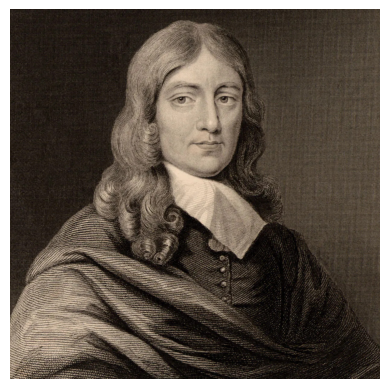

Of Mans First Disobedience, and the Fruit
Of that Forbidden Tree, whose mortal tast
Brought Death into the World, and all our woe,
With loss of Eden, till one greater Man
Restore us, and regain the blissful Seat,
Sing Heav’nly Muse, that on the secret top
Of Oreb, or of Sinai, didst inspire
That Shepherd, who first taught the chosen Seed,
In the Beginning how the Heav’ns and Earth
Rose out of Chaos: Or if Sion Hill
Delight thee more, and Siloa’s Brook that flow’d
Fast by the Oracle of God; I the


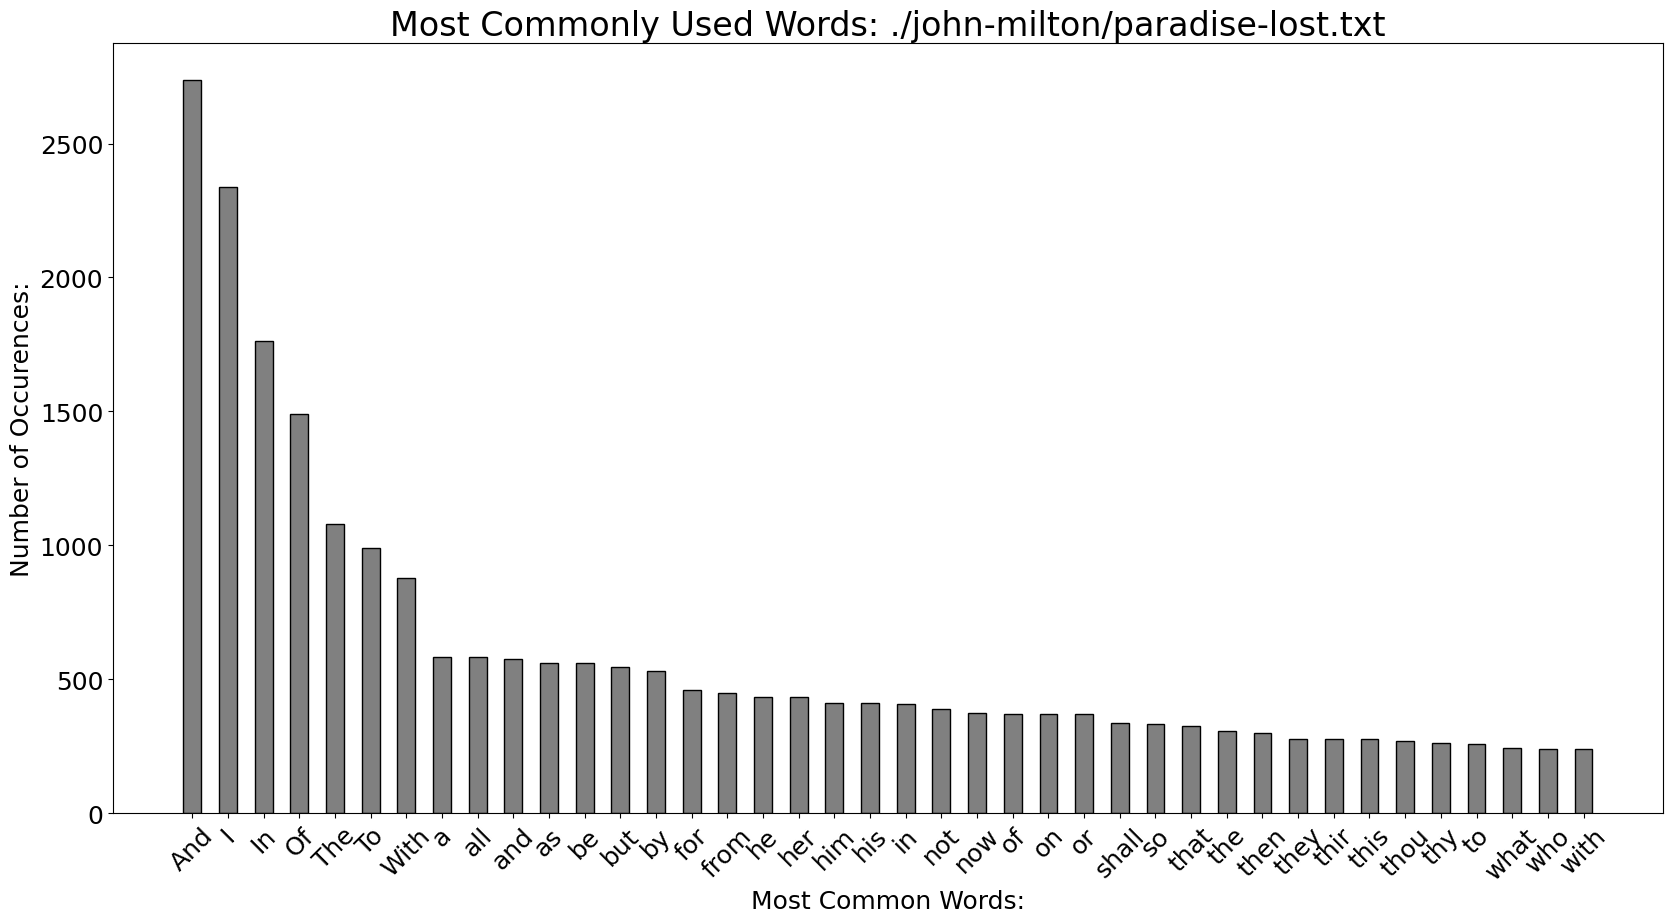

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 4)              112       
                                                                 
 lstm_1 (LSTM)               (None, 2, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_3 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_4 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_5 (LSTM)               (None, 2, 2)              88        
                                                                 
Total params: 2248 (8.78 KB)
Trainable params: 2248 (8.7

In [17]:
main("john-milton", "paradise-lost.txt")

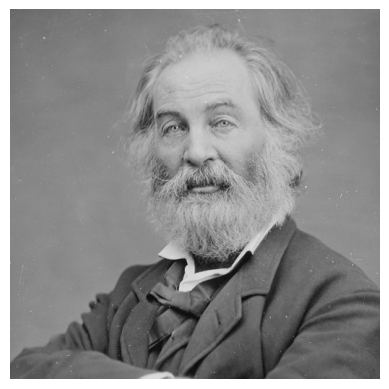

I celebrate myself, and sing myself,
And what I assume you shall assume,
For every atom belonging to me as good belongs to you.
I loafe and invite my soul,
I lean and loafe at my ease observing a spear of summer grass.

My tongue, every atom of my blood, form’d from this soil, this air,
Born here of parents born here from parents the same, and their parents the same,
I, now thirty-seven years old in perfect health begin,
Hoping to cease not till death.
Creeds and schools in abeyance,
Retiring ba


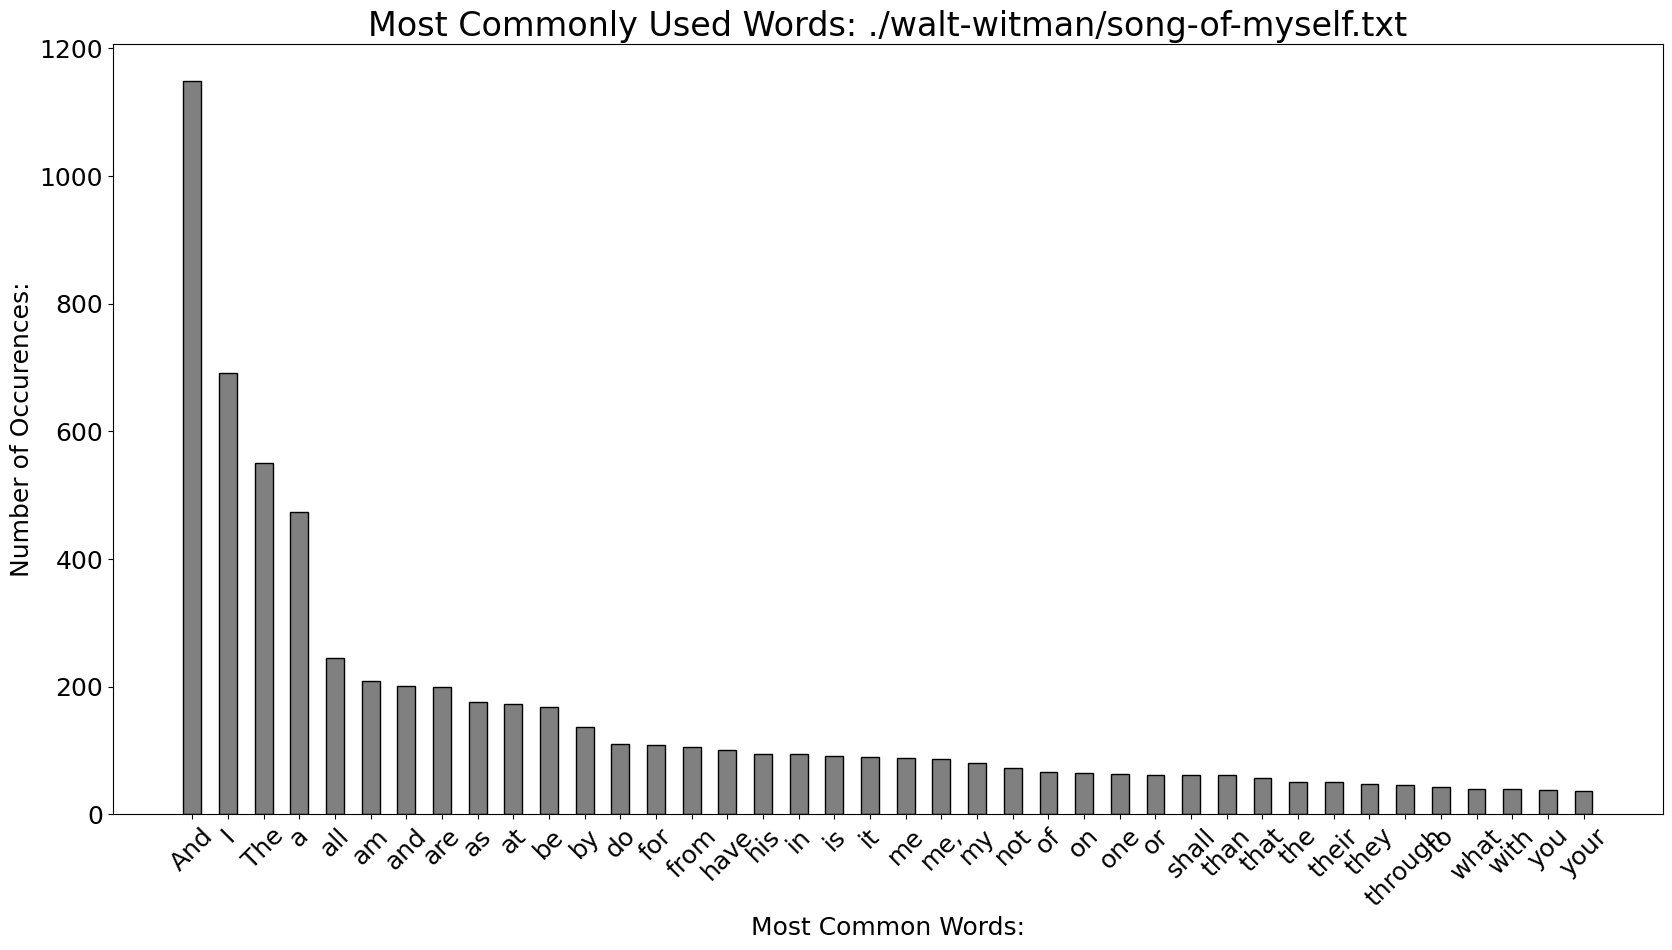

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 4)              112       
                                                                 
 lstm_13 (LSTM)              (None, 2, 8)              416       
                                                                 
 lstm_14 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_15 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_16 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_17 (LSTM)              (None, 2, 2)              88        
                                                                 
Total params: 2248 (8.78 KB)
Trainable params: 2248 (8

In [ ]:
main("walt-witman", "song-of-myself.txt")

In [ ]:
main("tagore", "gitanjali.txt")

In [ ]:
main("shakespeare", "rape-of-lucrece.txt")

In [ ]:
main("harivansh-rai", "madhushala.txt")